# Week 07 Exercises 

### 7.1 Calculating the Normalized Difference Index
From [https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)... the Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion: 

(NIR - R) / (NIR + R)

NDVI always ranges from -1 to +1. But there isn’t a distinct boundary for each type of land cover.For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there are likely no green leaves and it could even be an urbanized area.

For this first exercise you will calculate NDVI over the LMU campus.

1. Load both red (``` 'data/2023-02-22-sentinel-2-red-band.tiff' ```) and NIR (``` 'data/2023-02-22-sentinel-2-NIR-band.tiff' ```) bands from images taken from Sentinel-2 satellite over the LMU campus on February 22, 2023. Make sure when loading to use ```masked=True ```. Why do we want to do this? Check to see if the bounds, resolution and CRS are the same for both datasets. 

2. Calculate the NDVI. Export and save to a file as ``` 'data/2023-02-22-sentinel-2-NDVI.tiff' ```

3. Plot the NDVI data using the colormap ```RdYlGn```. Write 1-2 sentences describing patterns you notice.

4. Create a histogram with the custom bins: ```  bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] ```. Write 1-2 sentences explaining patterns you notice. Lastly, print the max and min values. 

In [12]:
# 1. Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping

reddata = rxr.open_rasterio('data/2023-02-22-sentinel-2-red-band.tiff', masked=True)
nirdata = rxr.open_rasterio('data/2023-02-22-sentinel-2-NIR-band.tiff', masked=True)

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

# View the Coordinate Reference System (CRS) 
print("The CRS for the red data is:", reddata.rio.crs)
print("The CRS for the nir data is:", nirdata.rio.crs)

print("The no data value is:", reddata.rio.nodata)
print("The no data value is:", nirdata.rio.nodata)

# Are the bounds the same?
print("Is the spatial extent the same?",
      reddata.rio.bounds() == nirdata.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      reddata.rio.resolution() == nirdata.rio.resolution())

The CRS for the red data is: EPSG:4326
The CRS for the nir data is: EPSG:4326
The no data value is: None
The no data value is: None
Is the spatial extent the same? True
Is the resolution the same? True


masked=True makes sure that no data values are not plotted and are assigned as NAN or no data

In [3]:
# 2. Calculate the NDVI
Calcndvi = (nirdata - reddata)/(nirdata + reddata)

# Export data to geotiff
ndvipath = 'data/2023-02-22-sentinel-2-NDVI.tiff'
Calcndvi.rio.to_raster(ndvipath)

# Reload data
ndvi = rxr.open_rasterio(ndvipath, masked=True).squeeze()
ndvi

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

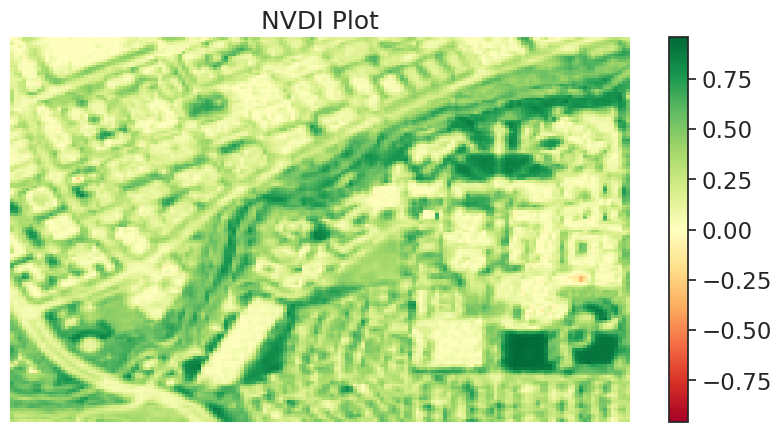

In [4]:
# 3. Plot data
f, ax = plt.subplots(figsize=(10,5))
ndvi.plot(cmap="RdYlGn")
ax.set(title= "NVDI Plot")
ax.set_axis_off()
plt.show()

Most of the map is yellow and red which means that it ranges between 0 and 30000. 

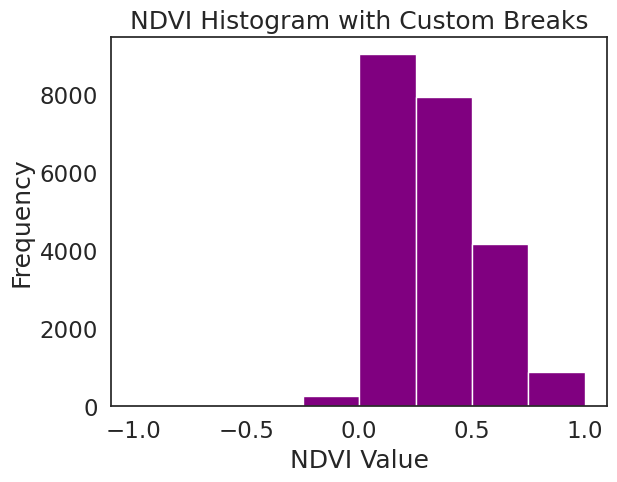

Min value: -0.3420191
Max value: 0.95758915


In [5]:
# Histogram with custom breaks
f, ax = plt.subplots()
ndvi.plot.hist(color="purple",
                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set(title="NDVI Histogram with Custom Breaks",
       xlabel="NDVI Value",
       ylabel="Frequency")

plt.show()

# Min and Max
print('Min value:', np.nanmin(ndvi))
print('Max value:', np.nanmax(ndvi))

There are the most values around 0 which means that it is an urbanized area. There are also a lot of numbers around 0-1 which means there is most likely a lot of grass in the area. There are some values below 0 which shows that there is some water in the area as well.

### 7.2  Manually Reclassify NDVI Data
Buildling on 7.1, let's now reclassify the NDVI data to more meaningful symbologies. 

1. Use the following breaks to reclassify the NDVI data:
- <0: water 
- 0 to 0.2: urban/barren
- 0.2 to 0.5: low vegetation
- $\gt$ 0.5: high vegetation

Note that you **do not** have to do any additional masking as your NoData mask already occured when loading in the data. 

2. Plot the data using the following parameters:
- ```colors = ['blue', 'beige', 'green', 'darkgreen']```
- ```class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]```

Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated. 

3. Create a histogram of the classified NDVI data. Give rough approximations of the percentages of each cateogry (i.e. ~20% water, ~40% barren/urban land etc.)

Min value: -0.3420191
Max value: 0.95758915


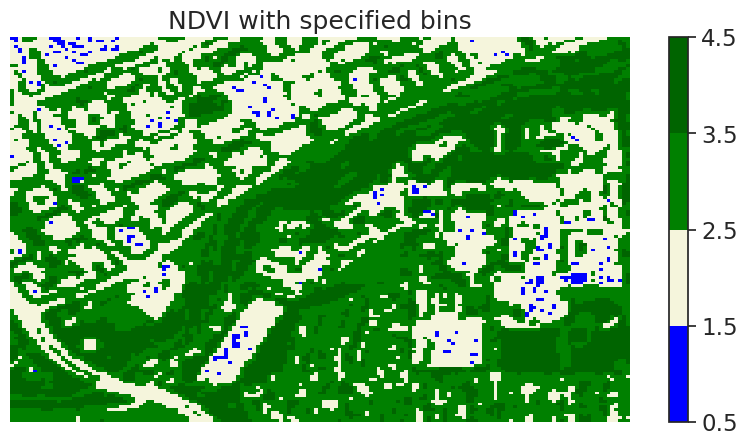

In [15]:
# Reclassify NDVI with breaks
# Check nodata value for array
ndvi.rio.nodata

# Min and Max
print('Min value:', np.nanmin(ndvi))
print('Max value:', np.nanmax(ndvi))

class_bins = [-np.inf,0,0.2,0.5,np.inf]

ndvinew = xr.apply_ufunc(np.digitize,
                                     ndvi,
                                     class_bins)

# Plot data using nicer colors
colors = ['blue', 'beige', 'green', 'darkgreen']
class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
ndvinew.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="NDVI with specified bins")
ax.set_axis_off()
plt.show()

Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated.

This classification clearly shows which areas belong to which categories. It is easy to tell what areas are densly vegetated, buildings, roads and water. It gives a good general idea of the area but it is super pixilated so it does not give a super accurate or detailed view. Overall what you would see walking around campus would align with this map well. 

[Text(0.5, 1.0, 'NDVI Histogram with Custom Breaks'),
 Text(0.5, 0, 'NDVI Value'),
 Text(0, 0.5, 'Frequency')]

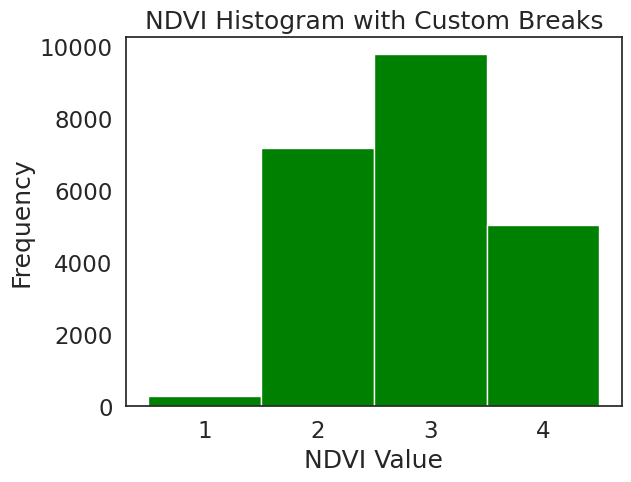

In [21]:
# Histogram with custom breaks
f, ax = plt.subplots()
ndvinew.plot.hist(color="green",
                        bins=[0.5, 1.5, 2.5, 3.5, 4.5])
ax.set(title="NDVI Histogram with Custom Breaks",
       xlabel="NDVI Value",
       ylabel="Frequency")

<0: water
0 to 0.2: urban/barren
0.2 to 0.5: low vegetation
>0.5: high vegetation

I dont know why the x axis isnt showing up as 0-0.5 but assuming that they did this would be the breakdown.
5% water
35% urban/barren
50% low vegetation
20% high vegetation